In [3]:
import pandas as pd 
import numpy as np 
import json 
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option('display.max_columns', 5)
pd.set_option('display.max_colwidth', 20)
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation



# 1. Data Cleaning

## 1-1 Data Import and Initial Exploration

In [4]:
# import data
df = pd.read_csv('resume_no_job_description.csv')
df2 = pd.read_csv('resume_with_job_description.csv')

In [5]:
df.head()

,id,content
0,clezbskz2000ryi2...,"{""awards"": {""awa..."
1,clezeac8k001myg2...,"{""awards"": {""awa..."
2,clezh9pxu0185yp2...,"{""awards"": {""awa..."
3,clf06bf5b014dx22...,"{""awards"": {""awa..."
4,clezdavhy000eyg2...,"{""awards"": {""awa..."


In [6]:
df2.head()

,id,content,jobDescription
0,clg43d9an007gx02...,"{""awards"": {""awa...",Job Posting:\nDo...
1,clg3itetj006jx92...,"{""awards"": {""awa...",Tasks:\n\nCreati...
2,clg3iy1sd007rx32...,"{""awards"": {""awa...",Responsibilities...
3,clg5j15lz00k3x02...,"{""awards"": {""awa...",What is Talentpo...
4,clg43pte600ddya2...,"{""awards"": {""awa...",Hyperproof is hi...


In [7]:
print("Number of unique IDs in DF:", df['id'].nunique())
print("Number of unique IDs in DF2:", df2['id'].nunique())

Number of unique IDs in DF: 13198
Number of unique IDs in DF2: 11976


- ID values in DF1 and DF2 are all unique, which means **no users use CoverQuick more than once** or they **use different IDs each time**.

In [8]:
common_ids = set(df['id']).intersection(set(df2['id']))
print("Number of common IDs:",len(common_ids))

Number of common IDs: 0


- IDs in DF1 and DF2 do not have any intersections, which means **no users use both the non-jd version and the jd version of Coverquick** or they **use different IDs**

In [9]:
df = df.drop('id', axis=1)
df2 = df2.drop('id', axis=1)

- id columns are dropped in both df and df2

## 1-2 Data Cleaning :JSON Flattening 

### 1-2-1Flattening First-layer Objects(Step 1)

#### 1-2-1-1 Flattening First-layer Objects("Resume with No Descriptions")

In [10]:
# Convert the JSON-formatted content strings to Python dictionaries
df['content']= df['content'].apply(json.loads)

In [11]:
# Flatten the first-layer JSON objects
d = pd.json_normalize(df['content'],sep='_', # nested keys separated by _
                      errors='ignore' # in case there are empty values
                      )

In [12]:
d.head()

,awards_awards,header_role,...,accomplishments_text,accomplishments_visible
0,[],,...,,True
1,[],,...,,True
2,[],,...,,True
3,[],,...,,True
4,[],,...,,True


After flattening, we've got **columns containing strings** and **columns containing lists of nested objects("[]")**. 

In [13]:
d = d.drop(['header_role'], axis=1)

"head_role" does not contain any values, so we dropped it.

In [14]:
# Rename the columns for easier reference
d.rename(columns={'awards_awards':'awards','header_contact_city': 'city', 'header_contact_state': 'state', 'skills_skills': 'skills',
                              'header_contact_country':'country','projects_projects':'project','volunteer_volunteer':'volunteer','experience_experience':'experience',
                              'references_references':'references','publications_publications':'publications','certifications_certifications':'certifications',
                              'education_education':'education'}, inplace=True)

In [15]:
d.head()

,awards,city,...,accomplishments_text,accomplishments_visible
0,[],Algiers / Hussei...,...,,True
1,[],Kisii,...,,True
2,[],Nairobi,...,,True
3,[],NAIROBI,...,,True
4,[],Machakos,...,,True


- **'awards', 'skills','project','education','volunteer','experience','references','publications','certifications'** contains lists of dictionaries. 
- Within each list of dictionaries, dictionaries **have the same keys**, and the numbers of dictionaries vary

In [16]:
d.columns

Index(['awards', 'city', 'state', 'country', 'skills', 'summary_text',
       'summary_visible', 'project', 'education', 'volunteer', 'experience',
       'references', 'publications', 'certifications', 'accomplishments_text',
       'accomplishments_visible'],
      dtype='object')

In [17]:
# Export the flattened data to a CSV
d.to_csv('resume_no_job_description_stage1.csv', index=False)

#### 1-2-1-2 Flattening First-layer Objects("Resume with Descriptions")

In [18]:
# Convert the JSON-formatted content strings to Python dictionaries
df2['content']= df2['content'].apply(json.loads)

In [19]:
# Flatten the nested JSON data in the 'content' column into a flat DataFrame
d2 = pd.json_normalize(df2['content'],sep='_',errors='ignore')

In [20]:
d2.head()

,keywords,suggestedSkills,...,accomplishments_visible,accomplishments_diffedText
0,[admissions repr...,"[Compliance, Cli...",...,True,
1,[dashboard inter...,"[Analysis, Colle...",...,True,
2,"[product, desig...","[Vue, DevOps, De...",...,True,
3,"[flexibility, i...",[],...,True,
4,[product roadmap...,[Curiosity],...,True,


After flattening, we've got **columns containing strings** and **columns containing lists of nested objects("[]")**. 

In [21]:
# Rename the columns
d2.rename(columns={'awards_awards':'awards','header_contact_city': 'city', 'header_contact_state': 'state', 'skills_skills': 'skills',
                              'header_contact_country':'country','projects_projects':'project','volunteer_volunteer':'volunteer','experience_experience':'experience',
                              'references_references':'references','publications_publications':'publications','certifications_certifications':'certifications',
                              'education_education':'education'}, inplace=True)

drop"header_role"

In [22]:
d2 = d2.drop(['header_role'], axis=1)

In [23]:
d2.columns

Index(['keywords', 'suggestedSkills', 'awards', 'city', 'state', 'country',
       'skills', 'summary_text', 'summary_visible', 'summary_diffedText',
       'project', 'education', 'volunteer', 'experience', 'references',
       'publications', 'certifications', 'accomplishments_text',
       'accomplishments_visible', 'accomplishments_diffedText'],
      dtype='object')

In [24]:
d2.head()

,keywords,suggestedSkills,...,accomplishments_visible,accomplishments_diffedText
0,[admissions repr...,"[Compliance, Cli...",...,True,
1,[dashboard inter...,"[Analysis, Colle...",...,True,
2,"[product, desig...","[Vue, DevOps, De...",...,True,
3,"[flexibility, i...",[],...,True,
4,[product roadmap...,[Curiosity],...,True,


- **'keywords', 'suggestedSkills'** contains lists of words and no dictionaries. Since words don't follow a pattern in categories, these two columns do not to be extracted
- **'awards','skills','project','education','volunteer','experience','references','publications','certifications'** contains lists of JSON objects.

In [25]:
#d2.to_csv('resume_with_job_description_stage1.csv', index=False)

### 1-2-1 Step 2: Parsing Lists of Dictionaries

#### 1-2-1-1 Parsing Lists of Dictionaries (resume with no job description)

- By checking out numbers of dictionaries under each lists in Excel, we realized there are up to 43 dictionaries in one list. In this case, **flattening all keys and items and store them in different columns is not preferred**.
- The approach we took was to parse all items of one key and store them in the same column.

Define function parse_list() to **parse keys and items across dictionaries** in the list

In [26]:
def parse_list(x):
    if isinstance(x, list) and x:  # test whether list contains something
        aggregated_keys = {}   # initialize an empty dictionary
        for item in x:
            if isinstance(item, dict):   # test whether item is a dictionary
                for key, value in item.items():
                    if key in aggregated_keys:  # if key already exists in dictionary
                        aggregated_keys[key].append(value)  # append the new value to the existing array at that key
                    else: # if key does not exist in dictionary
                        aggregated_keys[key] = [value]  # add the key-value pair to the dictionary
        return pd.Series(aggregated_keys)    # convert the dictionary to a pandas Series
    else:
        return pd.Series({})  # if x is not a list, return an empty Series

Next, we  generated new columns with collection of items under the same key to and dropped the original columns by looping over columns with lists of dictionaries.

In [27]:
for col in ['awards', 'skills', 'project', 'education', 'volunteer', 'experience', 'references', 'publications', 'certifications']:   # Select Columns with lists of dictionaries
    parsed_df = d[col].apply(parse_list)   # apply the parse_list function to the column
    parsed_df.columns = [f'{col}_{x}' for x in parsed_df.columns]  # rename the columns
    d = pd.concat([d, parsed_df], axis=1)  # concatenate the parsed columns to the original data frame
    d.drop(col, axis=1, inplace=True) # drop the original columns

In [28]:
#check parsed columns
d.filter(regex='.*_.*', axis=1).head()

,summary_text,summary_visible,...,certifications_visible,certifications_dateReceived
0,,True,...,NaN,NaN
1,Organized and de...,True,...,NaN,NaN
2,Taking on challe...,True,...,"[True, True]","[October 2022, O..."
3,Ambitious studen...,True,...,NaN,NaN
4,Quality Control ...,True,...,[True],[May 2011]


58 columns are extracted from columns of lists of dictionaries

In [29]:
d.columns

Index(['city', 'state', 'country', 'summary_text', 'summary_visible',
       'accomplishments_text', 'accomplishments_visible', 'awards_name',
       'awards_issuer', 'awards_details', 'awards_visible',
       'awards_description', 'awards_dateReceived', 'skills_section',
       'skills_visible', 'skills_sectionName', 'project_link', 'project_title',
       'project_skills', 'project_endDate', 'project_visible',
       'project_startDate', 'project_description', 'education_GPA',
       'education_minor', 'education_awards', 'education_school',
       'education_program', 'education_visible', 'education_location',
       'education_courseWork', 'education_graduationDate', 'volunteer_title',
       'volunteer_endDate', 'volunteer_visible', 'volunteer_location',
       'volunteer_startDate', 'volunteer_description',
       'volunteer_organization', 'experience_title', 'experience_company',
       'experience_endDate', 'experience_visible', 'experience_location',
       'experience_startDa

**58** columns were extracted from columns containing lists of dictionaries.

In [30]:
#Rename Columns
d.rename(columns={'summary_text':'summary','header_contact_city': 'city', 'header_contact_state': 'state', 'skills_skills': 'skills',
                              'header_contact_country':'country','projects_projects':'project','volunteer_volunteer':'volunteer','experience_experience':'experience',
                              'references_references':'references','publications_publications':'publications','certifications_certifications':'certifications',
                              'education_education':'education'}, inplace=True)

In [31]:
d.to_csv('resume_no_job_description_stage2.csv', index=False)

#### 1-2-1-2 Parsing Lists of Dictionaries (resume with job descriptions)

Follow the same steps as in the previous dataset.

In [32]:
d2.head()

,keywords,suggestedSkills,...,accomplishments_visible,accomplishments_diffedText
0,[admissions repr...,"[Compliance, Cli...",...,True,
1,[dashboard inter...,"[Analysis, Colle...",...,True,
2,"[product, desig...","[Vue, DevOps, De...",...,True,
3,"[flexibility, i...",[],...,True,
4,[product roadmap...,[Curiosity],...,True,


In [33]:
for col in ['awards', 'skills', 'project', 'education', 'volunteer', 'experience', 'references', 'publications', 'certifications']:   # Select Columns with lists of dictionaries
    parsed_df = d2[col].apply(parse_list)   # apply the parse_list function to the column
    parsed_df.columns = [f'{col}_{x}' for x in parsed_df.columns]  # rename the columns
    d2 = pd.concat([d2, parsed_df], axis=1)  # concatenate the parsed columns to the original data frame
    d2.drop(col, axis=1, inplace=True) # drop the original columns

In [34]:
d2.head()

,keywords,suggestedSkills,...,certifications_visible,certifications_dateReceived
0,[admissions repr...,"[Compliance, Cli...",...,[True],[November 2021]
1,[dashboard inter...,"[Analysis, Colle...",...,"[True, True, True]","[May 2022, May 2..."
2,"[product, desig...","[Vue, DevOps, De...",...,NaN,NaN
3,"[flexibility, i...",[],...,NaN,NaN
4,[product roadmap...,[Curiosity],...,"[True, True]","[May 2022, Janua..."


In [35]:
d2.columns

Index(['keywords', 'suggestedSkills', 'city', 'state', 'country',
       'summary_text', 'summary_visible', 'summary_diffedText',
       'accomplishments_text', 'accomplishments_visible',
       'accomplishments_diffedText', 'awards_name', 'awards_issuer',
       'awards_details', 'awards_visible', 'awards_dateReceived',
       'awards_description', 'skills_section', 'skills_visible',
       'skills_sectionName', 'project_link', 'project_title', 'project_skills',
       'project_endDate', 'project_visible', 'project_startDate',
       'project_description', 'project_diffedDescription', 'education_GPA',
       'education_minor', 'education_awards', 'education_school',
       'education_program', 'education_visible', 'education_location',
       'education_courseWork', 'education_graduationDate', 'volunteer_title',
       'volunteer_endDate', 'volunteer_visible', 'volunteer_location',
       'volunteer_startDate', 'volunteer_description',
       'volunteer_organization', 'volunteer_diffe

In [36]:
d2.to_csv('resume_with_job_description_stage2.csv', index=False)

## 1-3 Data Cleaning :Choose and Rename Columns of Interest (Step3)

In [37]:
rnd= d.copy()  
rd = d2.copy()

drop all columns contain "visible" in the column name

In [38]:
rnd = rnd.drop(columns=[col for col in rnd.columns if 'visible' in col])
rd = rd.drop(columns=[col for col in rd.columns if 'visible' in col])


In [39]:
rd = rd.drop(columns=[col for col in rd.columns if 'diffed' in col])

In [40]:
rnd.columns

Index(['city', 'state', 'country', 'summary', 'accomplishments_text',
       'awards_name', 'awards_issuer', 'awards_details', 'awards_description',
       'awards_dateReceived', 'skills_section', 'skills_sectionName',
       'project_link', 'project_title', 'project_skills', 'project_endDate',
       'project_startDate', 'project_description', 'education_GPA',
       'education_minor', 'education_awards', 'education_school',
       'education_program', 'education_location', 'education_courseWork',
       'education_graduationDate', 'volunteer_title', 'volunteer_endDate',
       'volunteer_location', 'volunteer_startDate', 'volunteer_description',
       'volunteer_organization', 'experience_title', 'experience_company',
       'experience_endDate', 'experience_location', 'experience_startDate',
       'experience_description', 'references_name', 'references_email',
       'references_phoneNumber', 'references_relationship',
       'publications_date', 'publications_link', 'publication

In [41]:
rd.columns

Index(['keywords', 'suggestedSkills', 'city', 'state', 'country',
       'summary_text', 'accomplishments_text', 'awards_name', 'awards_issuer',
       'awards_details', 'awards_dateReceived', 'awards_description',
       'skills_section', 'skills_sectionName', 'project_link', 'project_title',
       'project_skills', 'project_endDate', 'project_startDate',
       'project_description', 'education_GPA', 'education_minor',
       'education_awards', 'education_school', 'education_program',
       'education_location', 'education_courseWork',
       'education_graduationDate', 'volunteer_title', 'volunteer_endDate',
       'volunteer_location', 'volunteer_startDate', 'volunteer_description',
       'volunteer_organization', 'experience_title', 'experience_company',
       'experience_endDate', 'experience_location', 'experience_startDate',
       'experience_description', 'references_name', 'references_email',
       'references_phoneNumber', 'references_relationship',
       'publicatio

drop other columns of no interest

In [42]:
rnd = rnd.drop(['awards_details','references_phoneNumber','publications_link','project_link','references_email'], axis=1)

In [43]:
rd = rd.drop(['awards_details','references_phoneNumber','publications_link','project_link','references_email'], axis=1)

In [44]:
rnd.columns

Index(['city', 'state', 'country', 'summary', 'accomplishments_text',
       'awards_name', 'awards_issuer', 'awards_description',
       'awards_dateReceived', 'skills_section', 'skills_sectionName',
       'project_title', 'project_skills', 'project_endDate',
       'project_startDate', 'project_description', 'education_GPA',
       'education_minor', 'education_awards', 'education_school',
       'education_program', 'education_location', 'education_courseWork',
       'education_graduationDate', 'volunteer_title', 'volunteer_endDate',
       'volunteer_location', 'volunteer_startDate', 'volunteer_description',
       'volunteer_organization', 'experience_title', 'experience_company',
       'experience_endDate', 'experience_location', 'experience_startDate',
       'experience_description', 'references_name', 'references_relationship',
       'publications_date', 'publications_name', 'publications_details',
       'publications_publisher', 'certifications_name',
       'certificati

In [45]:
rd.columns

Index(['keywords', 'suggestedSkills', 'city', 'state', 'country',
       'summary_text', 'accomplishments_text', 'awards_name', 'awards_issuer',
       'awards_dateReceived', 'awards_description', 'skills_section',
       'skills_sectionName', 'project_title', 'project_skills',
       'project_endDate', 'project_startDate', 'project_description',
       'education_GPA', 'education_minor', 'education_awards',
       'education_school', 'education_program', 'education_location',
       'education_courseWork', 'education_graduationDate', 'volunteer_title',
       'volunteer_endDate', 'volunteer_location', 'volunteer_startDate',
       'volunteer_description', 'volunteer_organization', 'experience_title',
       'experience_company', 'experience_endDate', 'experience_location',
       'experience_startDate', 'experience_description', 'references_name',
       'references_relationship', 'publications_date', 'publications_name',
       'publications_details', 'publications_publisher', 'certi

In [46]:
# Rename the columns for easier reference
rnd.rename(columns={'skills_section':'skills','skills_sectionName': 'skills_type'}, inplace=True)
rd.rename(columns={'skills_section':'skills','skills_sectionName': 'skills_type'}, inplace=True)

In [47]:
#rnd. to_csv('resume_no_job_description_stage3.csv', index=False)
#rd. to_csv('resume_with_job_description_stage3.csv', index=False)

## 1-4 Text Cleaning (Step 4)

In [48]:
rd4 = rd.copy()
rnd4 = rnd.copy()

### 1-4-1 Converting all columns into Strings

To work with text cleaning, all values should be strings.

In [49]:
def list_to_string(lst):
    if isinstance(lst, list):
        return ', '.join(lst)
    return lst

turn columns containing lists to strings and replace empty strings with nan

In [50]:
rnd4 = rnd4.applymap(list_to_string)
rd4 = rd4.applymap(list_to_string)

convert floats to strings

In [51]:
rnd4 = rnd4.astype(str)
rd4 = rd4.astype(str)

In [52]:
rnd4.head()

,city,state,...,certifications_issuer,certifications_dateReceived
0,Algiers / Hussei...,Algiers,...,nan,nan
1,Kisii,,...,nan,nan
2,Nairobi,Nairobi,...,St John Ambulanc...,"October 2022, Oc..."
3,NAIROBI,,...,nan,nan
4,Machakos,Machakos,...,Kenya Institute ...,May 2011


### 1-4-2 Converting values into nan

Convert NULL values into nan

Convert "," into NAn

In [53]:
# define a function to convert string values to NaN
def convert_to_nan(x):
    if isinstance(x, str) and x.strip() in [',', ',,', ',,,', ',,,,', ',,,,,', ',,,,,,', ',,,,,,,', ',,,,,,,,',',,,,,,,,']:
        return np.nan
    else:
        return x

In [54]:
rnd4.replace('',np.nan,inplace=True)
rd4.replace('',np.nan,inplace=True)

In [55]:
rd4 = rd4.applymap(convert_to_nan)
rnd4 = rnd4.applymap(convert_to_nan)

In [56]:
rd4.head()

,keywords,suggestedSkills,...,certifications_issuer,certifications_dateReceived
0,admissions repre...,"Compliance, Clie...",...,California River...,November 2021
1,dashboard interf...,"Analysis, Collec...",...,"Google, Google, ...","May 2022, May 20..."
2,"product, design...","Vue, DevOps, Del...",...,nan,nan
3,"flexibility, in...",NaN,...,nan,nan
4,product roadmaps...,Curiosity,...,Project Manageme...,"May 2022, Januar..."


### 1-4-2 Punctuations

#### 1-4-2-1 Remove Dots

In [57]:
def remove_dots(text):
    return text.replace('•', '')

In [58]:
#rd4 = rd4.applymap(remove_dots)
#rnd4 = rnd4.applymap(remove_dots)

Most columns contain lists instead of strings, we can directly work with the lists

#### 1-4-2-2 Remove Leading Comma

In [59]:
# define a function to remove leading commas from strings
def remove_leading_comma(x):
    if isinstance(x, str) and x.startswith(','):
        return x[1:]
    else:
        return x

In [60]:
rd4 = rd4.applymap(remove_leading_comma)
rnd4 = rnd4.applymap(remove_leading_comma)

### 1-4-2-3 Counting numbers of sections

Count numbers of sections in awards, skills, projects,educations, volunteer experience, experiences, references, publications and certifications

In [61]:
columns_to_count=['awards_name','skills','project_title','education_school','volunteer_endDate',
                  'volunteer_title','experience_title','references_name','publications_name',
                  'certifications_name']

In [62]:
# Loop through the columns and count the double quotes
for col in columns_to_count:
    # Create a new column to store the count of double quotes
    new_col = col + '_count'
    # Count the commas in the original column and store the counts in the new column
    rd4[new_col] = rd4[col].apply(lambda x: str(x).count(',') if str(x).count(',') > 1 else 0)
    # Count the double quotes in the original column and store the counts in the new column
    rd4[new_col] = rd4[col].apply(lambda x: str(x).count(','))

In [63]:
# Loop through the columns and count the double quotes
for col in columns_to_count:
    # Create a new column to store the count of double quotes
    new_col = col + '_count'
    # Count the commas in the original column and store the counts in the new column
    rnd4[new_col] = rnd4[col].apply(lambda x: str(x).count(',') if str(x).count(',') > 1 else 0)
    # Count the double quotes in the original column and store the counts in the new column
    rnd4[new_col] = rnd4[col].apply(lambda x: str(x).count(','))

In [64]:
#rnd4. to_csv('resume_no_job_description_stage4.csv', index=False)
#rd4. to_csv('resume_with_job_description_stage4.csv', index=False)

In [65]:
rd4.columns


Index(['keywords', 'suggestedSkills', 'city', 'state', 'country',
       'summary_text', 'accomplishments_text', 'awards_name', 'awards_issuer',
       'awards_dateReceived', 'awards_description', 'skills', 'skills_type',
       'project_title', 'project_skills', 'project_endDate',
       'project_startDate', 'project_description', 'education_GPA',
       'education_minor', 'education_awards', 'education_school',
       'education_program', 'education_location', 'education_courseWork',
       'education_graduationDate', 'volunteer_title', 'volunteer_endDate',
       'volunteer_location', 'volunteer_startDate', 'volunteer_description',
       'volunteer_organization', 'experience_title', 'experience_company',
       'experience_endDate', 'experience_location', 'experience_startDate',
       'experience_description', 'references_name', 'references_relationship',
       'publications_date', 'publications_name', 'publications_details',
       'publications_publisher', 'certifications_name'

# 2. EDA

2-1 Find two to three target industries that the majority of our users apply to. 

2-2 Discover trends in demographics and find which industries yield the best and the worst resumes. We will provide metrics for defining a "Good" resume.

2-3 Determine the approximate age range and experience level. 

2-4 Determine trends in experience and skills for these target users.

## 2-1-1 Topic Modeling with Latent Dirichlet Allocation (LDA) on 'Keywords' Column

In [66]:
X = rd4['keywords'].fillna('')
# Feature extraction using CountVectorizer
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
num_topics = 20  # Specify the number of topics you want to extract
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X_vectorized)

# Get the top keywords for each topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_keywords = [feature_names[i] for i in topic.argsort()[:-5 - 1:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_keywords)}")

# Assign topics to the documents
topic_assignments = lda.transform(X_vectorized)
rd4['topic'] = topic_assignments.argmax(axis=1)

# Analyze the assigned topics
topic_counts = rd4['topic'].value_counts()
print(topic_counts)



Topic 1: financial, management, accounting, reports, analysis
Topic 2: design, user, research, data, ux
Topic 3: customer, service, experience, support, product
Topic 4: skills, communication, detail, to, office
Topic 5: management, development, research, program, community
Topic 6: safety, quality, equipment, inventory, clinical
Topic 7: training, management, hr, development, learning
Topic 8: data, analysis, product, business, analytics
Topic 9: marketing, media, social, content, digital
Topic 10: and, security, risk, information, of
Topic 11: software, technical, support, skills, development
Topic 12: test, testing, agile, software, development
Topic 13: design, creative, adobe, video, digital
Topic 14: the, and, experience, other, ability
Topic 15: job, system, tracking, applicant, description
Topic 16: project, management, business, communication, planning
Topic 17: skills, environment, health, communication, help
Topic 18: sales, customer, business, client, relationships
Topic 19

Top three topics:

1.Topic 15: job, system, tracking, applicant, description

2.Topic 3: customer, service, experience, support, product

3.Topic 7: training, management, hr, development, learning


## 2-1-2 Industry Classification using Rule-based Approach with 'keywords' column

In [67]:

# # Define the rule-based patterns and their corresponding industries （10 sample industries）
# industry_patterns = {
#     'Healthcare': ['hospital', 'patient', 'medical', 'nurse', 'doctor'],
#     'Technology': ['software', 'technology', 'IT', 'developer', 'programming'],
#     'Finance': ['finance', 'banking', 'investment', 'accounting', 'financial'],
#     'Education': ['education', 'school', 'teacher', 'learning', 'student'],
#     'Retail': ['retail', 'store', 'sales', 'merchandise', 'customer'],
#     'Hospitality': ['hospitality', 'hotel', 'restaurant', 'catering', 'guest'],
#     'Marketing': ['marketing', 'advertising', 'branding', 'campaign', 'digital'],
#     'Consulting': ['consulting', 'strategy', 'management', 'advisor', 'solution'],
#     'Manufacturing': ['manufacturing', 'production', 'factory', 'supply', 'equipment'],
#     'Transportation': ['transportation', 'logistics', 'shipping', 'fleet', 'delivery']
#     # Add more industry patterns as needed
# }

# # Create a new column to store the assigned industry
# rd4['assigned_industry'] = ''

# # Iterate through each row and assign the industry based on the keyword patterns
# for index, row in rd4.iterrows():
#     keywords = row['keywords']
#     assigned_industry = None

#     # Check for null values
#     if pd.notnull(keywords):
#         keywords = keywords.lower()
        
#         # Check for pattern matches
#         for industry, patterns in industry_patterns.items():
#             if any(pattern in keywords for pattern in patterns):
#                 assigned_industry = industry
#                 break
    
#     # Assign the industry to the corresponding row
#     rd4.at[index, 'assigned_industry'] = assigned_industry

# # Display the assigned industries
# print(rd4['assigned_industry'].value_counts())



In [68]:
def prioritize_industries(assigned_industries):
    # Calculate the number of occurrences of industry words in the keywords for each industry
    industries_scores = {industry: sum(keyword in industry_patterns[industry] for keyword in keywords.lower().split())
                         for industry in assigned_industries}

    # Sort the industries based on their scores (number of occurrences) in descending order
    sorted_industries = sorted(industries_scores.items(), key=lambda x: x[1], reverse=True)

    # Return the industry with the highest score (most occurrences) as the final assigned industry
    return sorted_industries[0][0] if sorted_industries else None


# Define the rule-based patterns and their corresponding industries (10 sample industries)
industry_patterns = {
    'Healthcare': ['hospital', 'patient', 'medical', 'nurse', 'doctor'],
    'Technology': ['software', 'technology', 'IT', 'developer', 'programming'],
    'Finance': ['finance', 'banking', 'investment', 'accounting', 'financial'],
    'Education': ['education', 'school', 'teacher', 'learning', 'student'],
    'Retail': ['retail', 'store', 'sales', 'merchandise', 'customer'],
    'Hospitality': ['hospitality', 'hotel', 'restaurant', 'catering', 'guest'],
    'Marketing': ['marketing', 'advertising', 'branding', 'campaign', 'digital'],
    'Consulting': ['consulting', 'strategy', 'management', 'advisor', 'solution'],
    'Manufacturing': ['manufacturing', 'production', 'factory', 'supply', 'equipment'],
    'Transportation': ['transportation', 'logistics', 'shipping', 'fleet', 'delivery']
    # Add more industry patterns as needed
}

# Create a new column to store the assigned industry
rd4['assigned_industry'] = ''

# Iterate through each row and assign the industry based on the keyword patterns
for index, row in rd4.iterrows():
    keywords = row['keywords']
    assigned_industries = set()

    # Check for null values
    if pd.notnull(keywords):
        keywords = keywords.lower()

        # Check for pattern matches
        for industry, patterns in industry_patterns.items():
            if any(pattern in keywords for pattern in patterns):
                assigned_industries.add(industry)

    # Determine the final assigned industry based on priority or additional criteria
    if assigned_industries:
        # Use a prioritization mechanism or additional analysis to determine the final assigned industry
        final_industry = prioritize_industries(assigned_industries)  
        rd4.at[index, 'assigned_industry'] = final_industry
    else:
        rd4.at[index, 'assigned_industry'] = None  # No matching industry

# Display the assigned industries
print(rd4['assigned_industry'].value_counts())


Retail            2538
Consulting        2214
Technology        1690
Marketing         1112
Finance            793
Manufacturing      439
Transportation     393
Education          319
Healthcare         257
Hospitality         98
Name: assigned_industry, dtype: int64


In [69]:
rd4['assigned_industry'].head()

0     Education
1     Marketing
2    Technology
3    Consulting
4        Retail
Name: assigned_industry, dtype: object

In [70]:
rd4['assigned_industry'].head()

0     Education
1     Marketing
2    Technology
3    Consulting
4        Retail
Name: assigned_industry, dtype: object

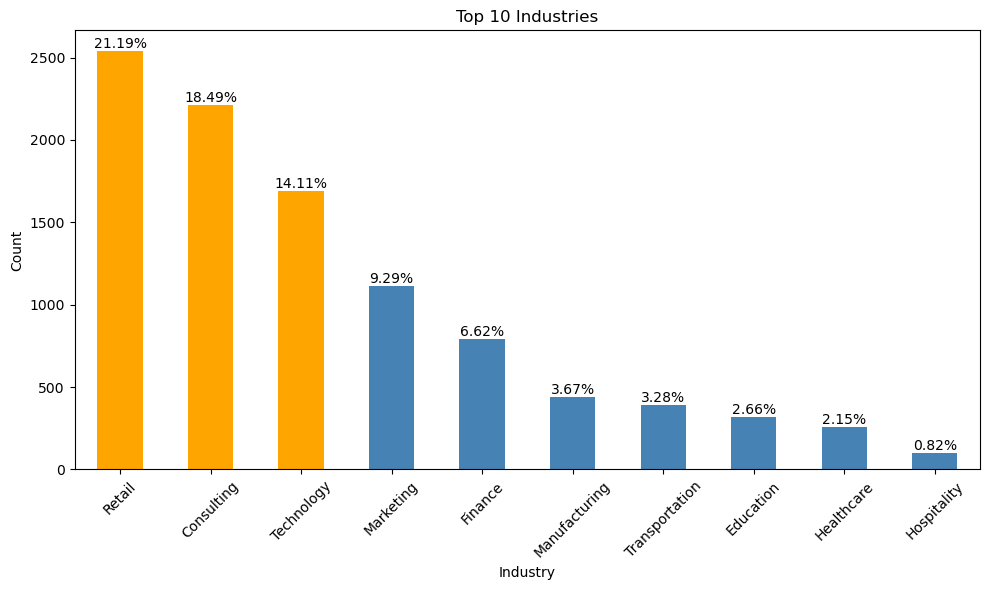

In [71]:
# Visualize the top 10 industries
industry_counts = rd4['assigned_industry'].value_counts()
industry_percentages = (industry_counts / len(rd4)) * 100

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = industry_counts.plot(kind='bar', color=['orange' if i < 3 else 'steelblue' for i in range(len(industry_counts))])
plt.title("Top 10 Industries")
plt.xlabel("Industry")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Adding percentages at the top of each bar
for i, v in enumerate(industry_counts):
    percentage = industry_percentages[i]
    plt.text(i, v, f"{percentage:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [72]:
rd4.columns

Index(['keywords', 'suggestedSkills', 'city', 'state', 'country',
       'summary_text', 'accomplishments_text', 'awards_name', 'awards_issuer',
       'awards_dateReceived', 'awards_description', 'skills', 'skills_type',
       'project_title', 'project_skills', 'project_endDate',
       'project_startDate', 'project_description', 'education_GPA',
       'education_minor', 'education_awards', 'education_school',
       'education_program', 'education_location', 'education_courseWork',
       'education_graduationDate', 'volunteer_title', 'volunteer_endDate',
       'volunteer_location', 'volunteer_startDate', 'volunteer_description',
       'volunteer_organization', 'experience_title', 'experience_company',
       'experience_endDate', 'experience_location', 'experience_startDate',
       'experience_description', 'references_name', 'references_relationship',
       'publications_date', 'publications_name', 'publications_details',
       'publications_publisher', 'certifications_name'

## 2-2  Discouver trends in demographics and find which industries yield the best and the worst resumes
### (Missing)

## 2-3 Determine the age range and experience level

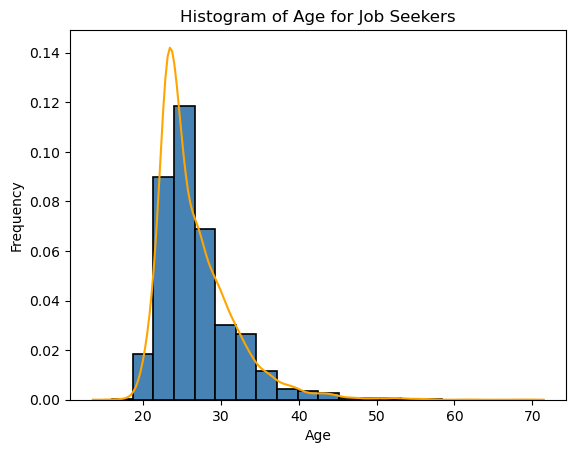

In [73]:
# Extract the age from graduation year assuming the average graduation age is 23
rnd4['graduation_year'] = rnd4['education_graduationDate'].str.extract(r'(\d{4})').astype(float) # only extract the first occurrence of a four-digit number (year) within each date value
rnd4['age'] = 2046 - rnd4['graduation_year']

# Plot the histogram
plt.hist(rnd4['age'], bins=20, color='steelblue', edgecolor='black', linewidth=1.2, density=True)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age for Job Seekers')

sns.kdeplot(rnd4[rnd4['age'] > 0]['age'], color='orange', linewidth=1.5, linestyle='-')
plt.show()


In [74]:
rnd4['age'].describe()

count    7195.000000
mean       26.621126
std         4.856506
min        16.000000
25%        23.000000
50%        25.000000
75%        29.000000
max        69.000000
Name: age, dtype: float64

In [75]:
rd4['experience_count'] = rd4['experience_title'].str.count(',') + 1

# Define the experience levels
experience_levels = {
    2: 'Entry Level',
    4: 'Mid Level',
    6: 'Senior Level',
    8: 'Executive Level',
    # Add more levels as needed
}

# Assign the experience level based on the count
rd4['experience_level'] = rd4['experience_count'].map(experience_levels)

# Display the result
print(rd4[['experience_title', 'experience_level']])


          experience_title experience_level
0      Lead IPM Technic...      Entry Level
1      UI/UX Designer, ...              NaN
2      Software Enginee...      Entry Level
3      CRM Specialist, ...              NaN
4      Customer Support...              NaN
...                    ...              ...
11971  Videographer/Vid...      Entry Level
11972  Video Editor, Ph...        Mid Level
11973  Teacher, Clerk-T...              NaN
11974  Video Editor, Ph...              NaN
11975  Video Editor, Ph...        Mid Level

[11976 rows x 2 columns]


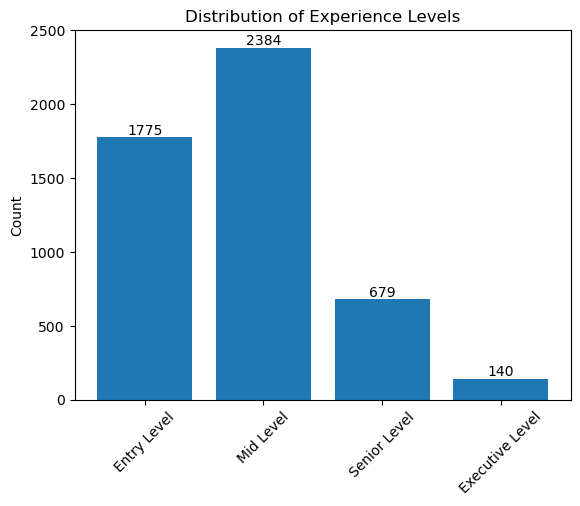

In [76]:
# Define the custom order of experience levels
custom_order = ['Entry Level', 'Mid Level', 'Senior Level', 'Executive Level']
# Sort the experience counts based on the custom order
experience_counts = rd4['experience_level'].value_counts().loc[custom_order]

plt.bar(experience_counts.index, experience_counts.values)
plt.ylabel('Count')
plt.title('Distribution of Experience Levels')

# Adding count labels at the top of each bar
for i, count in enumerate(experience_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)
plt.show()


## 2-4-1 Determine trends in skills

In [77]:
from collections import Counter

skills = rd4['skills']
skills = skills.astype(str)
skills = skills.dropna().str.split(', ')
# Flatten the list of skills and remove empty or whitespace-only skills
all_skills = [skill.strip() for sublist in skills for skill in sublist if skill.strip() != '']  # and revove the empty strings
# Calculate skill frequencies
skill_frequencies = Counter(all_skills)

# Exclude missing values from the skill frequencies
skill_frequencies = {skill: frequency for skill, frequency in skill_frequencies.items() if skill != 'nan'}

# Sort the skill frequencies in descending order
sorted_skills = sorted(skill_frequencies.items(), key=lambda x: x[1], reverse=True)

# Select the top N skills
top_skills = sorted_skills[:15]  # Change the number as per your requirement

# Print the top skills and their frequencies
for skill, frequency in top_skills:
    print(skill, "-", frequency)


Excel - 1871
Python - 1668
SQL - 1169
JavaScript - 1097
HTML - 1022
Word - 940
PowerPoint - 885
CSS - 824
Tableau - 783
Communication - 765
Microsoft Office - 686
Project Management - 673
Microsoft Office Suite - 639
Git - 629
Trello - 587


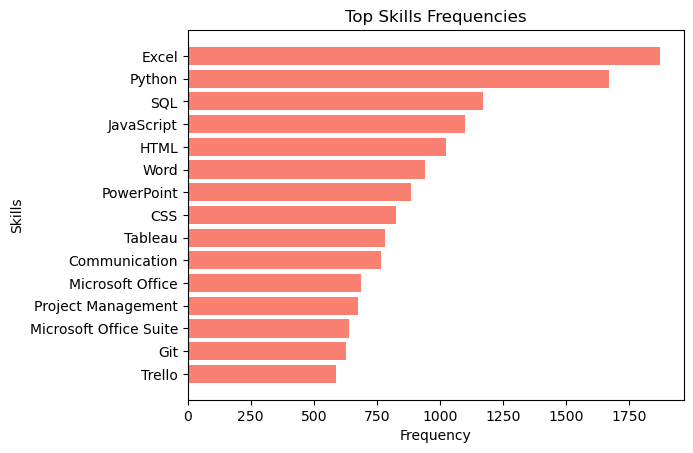

In [78]:
# Extract the skills and frequencies, excluding empty skills
skills = [skill for skill, _ in top_skills]
frequencies = [frequency for skill, frequency in top_skills]

# Reverse the lists to plot in descending order
skills.reverse()
frequencies.reverse()

plt.barh(skills, frequencies,color='salmon')
plt.xlabel('Frequency')
plt.ylabel('Skills')
plt.title('Top Skills Frequencies')
plt.show()


In [79]:
skills = rd4['suggestedSkills']
skills = skills.astype(str)
skills = skills.dropna().str.split(', ')
# Flatten the list of skills
all_skills = [skill.strip() for sublist in skills for skill in sublist if skill.strip() != '']  # and revove the empty strings

# Calculate skill frequencies
skill_frequencies = Counter(all_skills)

# Exclude missing values from the skill frequencies
skill_frequencies = {skill: frequency for skill, frequency in skill_frequencies.items() if skill != 'nan'}

# Sort the skill frequencies in descending order
sorted_skills = sorted(skill_frequencies.items(), key=lambda x: x[1], reverse=True)

# Select the top N skills
top_skills = sorted_skills[:15]  # Change the number as per your requirement

# Print the top skills and their frequencies
for skill, frequency in top_skills:
    print(skill, "-", frequency)


Manager - 820
Management - 789
Office - 772
Microsoft - 772
English - 591
Business - 472
Customer - 455
Marketing - 400
Development - 393
Excel - 338
Manage - 334
Operations - 295
Suite - 290
Systems - 290
Sales - 225


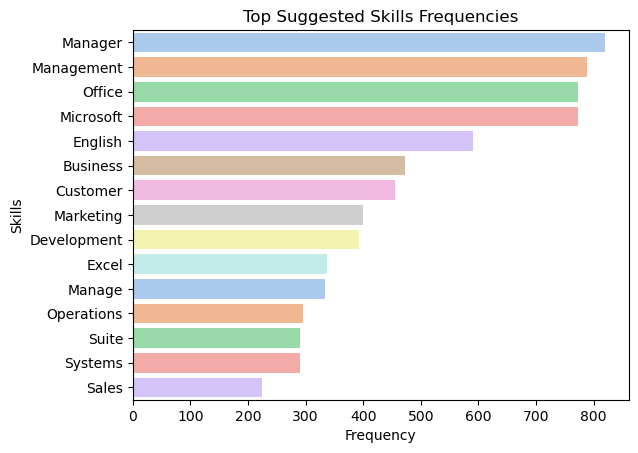

In [80]:
# Extract the skills and frequencies
skills = [skill for skill, _ in top_skills]
frequencies = [frequency for _, frequency in top_skills]

# Choose a palette
palette = "pastel"  # Example palette, you can choose any other palette

# Create the bar plot using seaborn
sns.barplot(x=frequencies, y=skills, palette=palette)
plt.xlabel('Frequency')
plt.ylabel('Skills')
plt.title('Top Suggested Skills Frequencies')
plt.show()



## 2-4-2 Determine Trends in Experiences

#### Top Experience Titles

In [81]:
from collections import Counter

experience_titles = rd4['experience_title']
experience_titles = experience_titles.astype(str)
experience_titles = experience_titles.dropna().str.split(', ')
# Flatten the list of experience titles
all_titles = [title.strip() for sublist in experience_titles for title in sublist if title.strip() != '']
# Calculate title frequencies
title_freqencies = Counter(all_titles)

# Exclude missing values from the skill frequencies
title_frequencies = {title: frequency for title, frequency in title_freqencies.items() if title != 'nan'}

# Sort the title frequencies in descending order
sorted_titles = sorted(title_frequencies.items(), key=lambda x: x[1], reverse=True)

# Select the top N titles
top_titles = sorted_titles[:15]  # Change the number as per your requirement

# Print the top titles and their frequencies
for title, frequency in top_titles:
    print(title, "-", frequency)

Photographer & Editor - 434
Intern - 364
Project Manager - 338
Sales Associate - 328
Video Editor (Remote) - 298
Customer Service Representative - 281
Graphic Web Designer & Developer (Remote) - 278
Video Editor - 235
Project Officer - 194
CTO - 177
Research Assistant - 167
Field Manager - 164
Field Officer - 162
Summer Analyst - 160
Systems Engineer Intern - 159


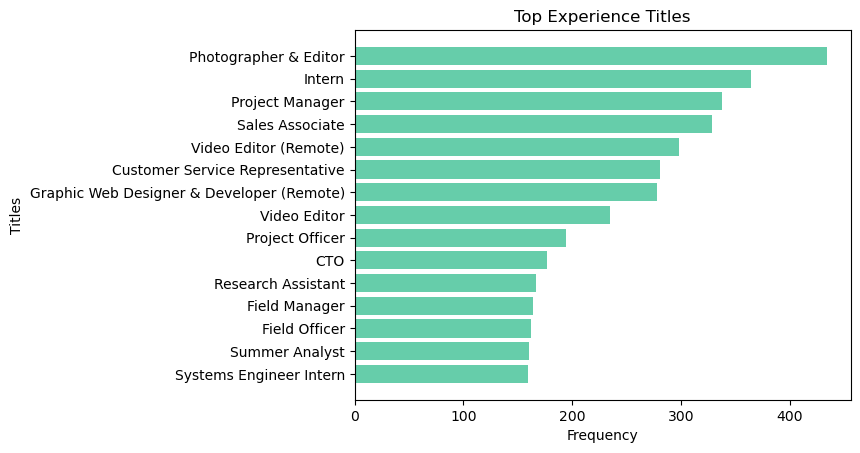

In [82]:
# Extract the titles and frequencies, excluding empty titles
titles = [title for title, frequency in top_titles if title != '']
frequencies = [frequency for title, frequency in top_titles if title != '']

# Reverse the lists to plot in descending order
titles.reverse()
frequencies.reverse()

plt.barh(titles, frequencies,color='mediumaquamarine')
plt.xlabel('Frequency')
plt.ylabel('Titles')
plt.title('Top Experience Titles')
plt.show()

#### Top Experience Companies

In [83]:
from collections import Counter

experience_companies = rd4['experience_company']
experience_companies = experience_companies.astype(str)
experience_companies = experience_companies.dropna().str.split(', ')
# Flatten the list
all_companies = [company.strip() for sublist in experience_companies for company in sublist if company.strip() != '']
# Calculate title frequencies
company_freqencies = Counter(all_companies)

# Exclude missing values
company_frequencies = {company: frequency for company, frequency in company_freqencies.items() if company != 'nan'}

# Sort the company frequencies in descending order
sorted_companies = sorted(company_frequencies.items(), key=lambda x: x[1], reverse=True)

# Select the top N companies
top_companies = sorted_companies[:15]  # Change the number as per your requirement

# Print the top companies and their frequencies
for company, frequency in top_companies:
    print(company, "-", frequency)

Best View Imaging - 434
Livingstonia Synod AIDS Programme (LISAP) - 326
Lamacchia Realty - 300
The Master Teacher - 298
Gifts Just For You - 278
Goldman Sachs - 246
Gifted music records - 224
Amazon - 197
Inc. - 179
LLC - 178
THE UNIVERSITY OF NORTH TEXAS HEALTH SCIENCE CENTER - 178
Freelance - 165
Nguvu Foundation - 165
Give Directly - 163
CoverQuick - 159


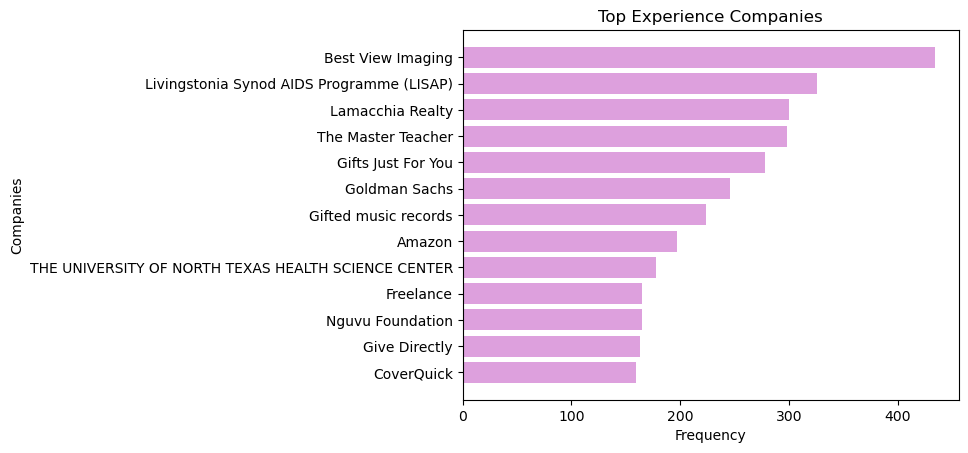

In [84]:
# Extract the companies and frequencies, excluding empty companies
companies = [company for company, frequency in top_companies if title != '']
frequencies = [frequency for company, frequency in top_companies if title != '']

# Reverse the lists to plot in descending order
companies.reverse()
frequencies.reverse()

# Remove sixth and seventh bars from the bottom
companies_modified = companies[:5] + companies[7:]
frequencies_modified = frequencies[:5] + frequencies[7:]

plt.barh(companies_modified, frequencies_modified,color='plum')
plt.xlabel('Frequency')
plt.ylabel('Companies')
plt.title('Top Experience Companies')
plt.show()

#### Top Experience Title Counts

In [85]:
from collections import Counter

counts = rd4['experience_title_count']
counts = counts.astype(str)
counts = counts.dropna().str.split(', ')
# Flatten the list
all_counts = [count.strip() for sublist in counts for count in sublist if count.strip() != '']
# Calculate count frequencies
count_freqencies = Counter(all_counts)

# Exclude missing values
count_frequencies = {count: frequency for count, frequency in count_freqencies.items() if count != 'nan'}

# Sort the count frequencies in descending order
sorted_counts = sorted(count_frequencies.items(), key=lambda x: x[1], reverse=True)

# Select the top N counts
top_counts = sorted_counts[:10]  # Change the number as per your requirement

# Print the top counts and their frequencies
for count, frequency in top_counts:
    print(count, "-", frequency)

2 - 3205
3 - 2384
1 - 1775
0 - 1758
4 - 1320
5 - 679
6 - 365
7 - 140
9 - 131
8 - 130


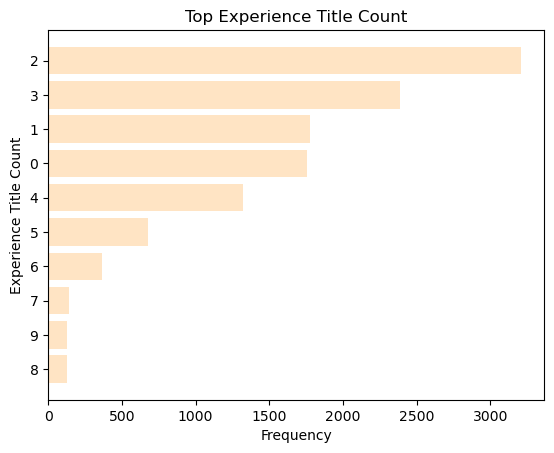

In [86]:
# Extract the counts and frequencies, excluding empty counts
counts = [count for count, frequency in top_counts if count != '']
frequencies = [frequency for count, frequency in top_counts if count != '']

# Reverse the lists to plot in descending order
counts.reverse()
frequencies.reverse()

plt.barh(counts, frequencies,color='bisque')
plt.xlabel('Frequency')
plt.ylabel('Experience Title Count')
plt.title('Top Experience Title Count')
plt.show()

#### Top Experience Locations

In [87]:
from collections import Counter

locations = rd4['experience_location']
locations = locations.astype(str)
locations = locations.dropna().str.split(', ')
# Flatten the list
all_locations = [location.strip() for sublist in locations for location in sublist if location.strip() != '']
# Calculate location frequencies
location_freqencies = Counter(all_locations)

# Exclude missing values
location_frequencies = {location: frequency for location, frequency in location_freqencies.items() if location != 'nan'}

# Sort the location frequencies in descending order
sorted_locations = sorted(location_frequencies.items(), key=lambda x: x[1], reverse=True)

# Select the top N locations
top_locations = sorted_locations[:15]  # Change the number as per your requirement

# Print the top locations and their frequencies
for location, frequency in top_locations:
    print(location, "-", frequency)

Remote - 1878
Nairobi - 1189
CA - 1067
Toronto - 1053
NY - 1026
MA - 985
New York - 880
Nigeria - 806
Kenya - 800
Ghana - 786
Lagos - 782
FL - 650
TX - 602
ON - 593
London - 547


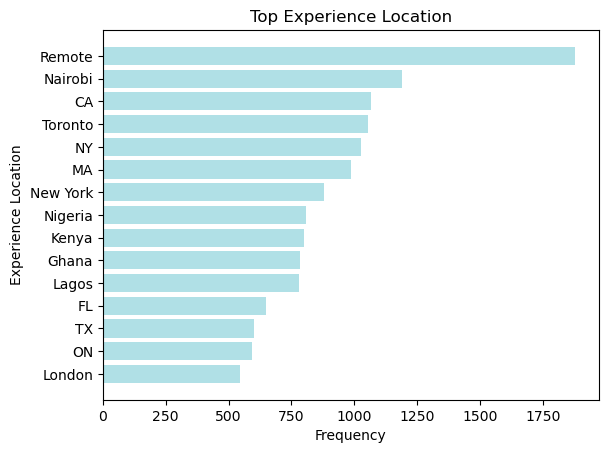

In [88]:
# Extract the locations and frequencies, excluding empty companies
locations = [location for location, frequency in top_locations if location != '']
frequencies = [frequency for location, frequency in top_locations if location != '']

# Reverse the lists to plot in descending order
locations.reverse()
frequencies.reverse()

plt.barh(locations, frequencies,color='powderblue')
plt.xlabel('Frequency')
plt.ylabel('Experience Location')
plt.title('Top Experience Location')
plt.show()

# 3 Resume Quality

## 3-1 Important Sections (work experience, education, project)

In [89]:
import pandas as pd

df_section = rd4[["experience_title_count","education_school_count","project_title_count"]]

In [90]:
# Count the number of rows where all column values are at least 1
count = len(df_section[(df_section >= 1).all(axis=1)])

# Print the result
print("Number of rows with all column values at least 1:", count)

Number of rows with all column values at least 1: 737


In [91]:
rd4.shape

(11976, 61)

## 3-2 Excessive Bullet Points (more than 10)

In [92]:
# Assuming you have a DataFrame named 'df' with the relevant columns
columns_to_check = ["volunteer_description", "accomplishments_text", "project_description", "experience_description", "publications_details"]

# Define a function to count bullet points in a given text
def count_bullet_points(text):
    if isinstance(text, str):
        return text.count('-')  # Change the bullet point character as needed
    else:
        return 0

# Apply the function to each row and assign the counts to a new column
rd4['bullet_point_count'] = rd4[columns_to_check].apply(lambda row: sum(count_bullet_points(row[col]) for col in columns_to_check), axis=1)

# Print the DataFrame with the new column
print(rd4)

                  keywords      suggestedSkills  ... experience_level  \
0      admissions repre...  Compliance, Clie...  ...      Entry Level   
1      dashboard interf...  Analysis, Collec...  ...              NaN   
2      product,  design...  Vue, DevOps, Del...  ...      Entry Level   
3      flexibility,  in...                  NaN  ...              NaN   
4      product roadmaps...            Curiosity  ...              NaN   
...                    ...                  ...  ...              ...   
11971  content,  ideati...  Instagram, Calen...  ...      Entry Level   
11972  adobe premiere, ...  Broadcast, Promo...  ...        Mid Level   
11973  write,  content,...                  NaN  ...              NaN   
11974  accountable,  ch...                  NaN  ...              NaN   
11975  product,  produc...          Communicate  ...        Mid Level   

      bullet_point_count  
0                      7  
1                      0  
2                      7  
3              

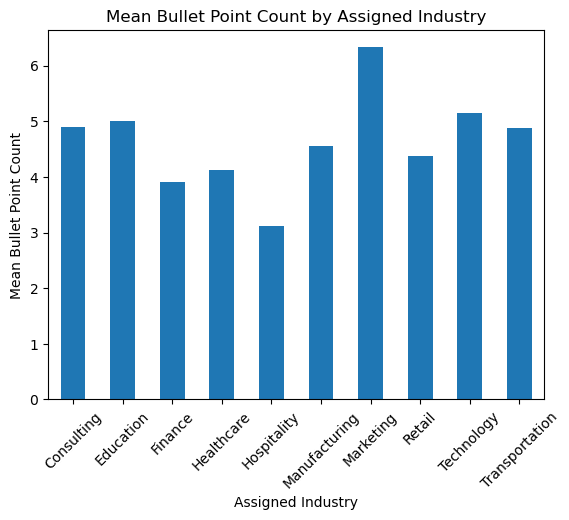

In [93]:
rd4.groupby('assigned_industry')['bullet_point_count'].mean().plot(kind='bar')

# Adding labels and title
plt.xlabel('Assigned Industry')
plt.ylabel('Mean Bullet Point Count')
plt.title('Mean Bullet Point Count by Assigned Industry')

# Rotating x-axis labels if needed
plt.xticks(rotation=45)

# Displaying the plot
plt.show()

## 3-3 Resume Length(ideal: 300-500 words)

In [94]:
rd4['totalwords'] = rd4.apply(lambda row: sum([len(str(x).split()) for x in row]), axis=1)

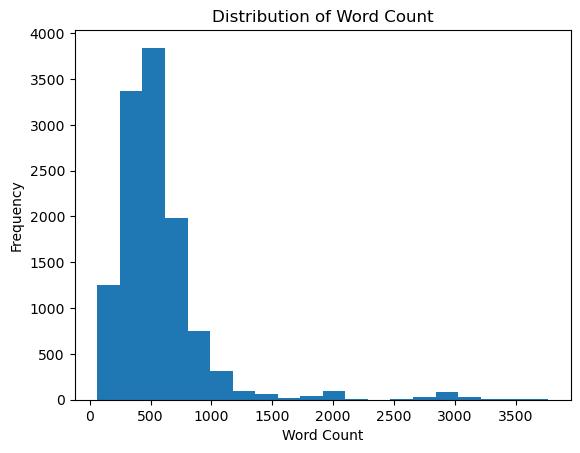

In [95]:
# Plot the distribution of word_count_column
plt.hist(rd4['totalwords'], bins=20)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count')
plt.show()

## 3-4 Use of Action Verbs (in each bullet point of each user's resume)

In [96]:
import pandas as pd
import re

# Define a list of 201 action verbs
words = '''Administered Assigned Authorized Coached Coordinated Developed Directed Empowered Enabled Enforced Established Facilitated Guided
 Headed Implemented Initiated Operated Orchestrated Organized Overhauled Oversaw Presided Spearheaded Streamlined Supervised Adapted Authored 
 Composed Conceived Conceptualized Curated Designed Directed Drafted Edited Illustrated Performed Photographed Proofread Published Revised 
 Storyboarded Translated Wrote Accomplished Actualized Administered Completed Developed Enforced Executed Fulfilled Implemented Operated 
 Organized Performed Prepared Realized Aided Assisted Coached Co-authored Collaborated Cooperated Coproduced Fostered Helped Joined Married 
 Melded Merged Motivated Participated Partnered Persuaded Supported Teamed Trained Addressed Authored Corresponded Critiqued Documented 
 Edited Explained Interpreted Instructed Lectured Lobbied Mediated Moderated Performed Persuaded Presented Promoted Proposed Spoke Wrote 
 Accomplished Accelerated Achieved Attained Boosted Completed Decreased Delivered Drove Exceeded Expanded Expedited Grew Improved Maximized 
 Outperformed Raised Reached Strengthened Surpassed Analyzed Assessed Collected Diagnosed Discovered Evaluated Examined Explored Forecasted 
 Gathered Inspected Investigated Mapped Measured Probed Reported Researched Studied Surveyed Tested Adjusted Analyzed Appraised Assessed 
 Audited Balanced Budgeted Calculated Converted Estimated Evaluated Forecasted Invested Lowered Measured Netted Projected Qualified Reduced 
 Researched Coded Computed Constructed Debugged Deployed Designed Developed Devised Diagnosed Engineered Maintained Modified Networked 
 Operated Overhauled Programmed Standardized Tested Updated Upgraded Advised Coached Communicated Encouraged Evaluated Explained Guided 
 Individualized Instructed Lectured Motivated Persuaded Set goals Stimulated Taught Tested Tutored Worked Responsible Managed Led Assisted'''
word_list = words.split()

# Convert each element to string
word_list = list(map(str, word_list))  

print(word_list)
print(len(word_list))

['Administered', 'Assigned', 'Authorized', 'Coached', 'Coordinated', 'Developed', 'Directed', 'Empowered', 'Enabled', 'Enforced', 'Established', 'Facilitated', 'Guided', 'Headed', 'Implemented', 'Initiated', 'Operated', 'Orchestrated', 'Organized', 'Overhauled', 'Oversaw', 'Presided', 'Spearheaded', 'Streamlined', 'Supervised', 'Adapted', 'Authored', 'Composed', 'Conceived', 'Conceptualized', 'Curated', 'Designed', 'Directed', 'Drafted', 'Edited', 'Illustrated', 'Performed', 'Photographed', 'Proofread', 'Published', 'Revised', 'Storyboarded', 'Translated', 'Wrote', 'Accomplished', 'Actualized', 'Administered', 'Completed', 'Developed', 'Enforced', 'Executed', 'Fulfilled', 'Implemented', 'Operated', 'Organized', 'Performed', 'Prepared', 'Realized', 'Aided', 'Assisted', 'Coached', 'Co-authored', 'Collaborated', 'Cooperated', 'Coproduced', 'Fostered', 'Helped', 'Joined', 'Married', 'Melded', 'Merged', 'Motivated', 'Participated', 'Partnered', 'Persuaded', 'Supported', 'Teamed', 'Trained',

In [102]:
# select columns that have bullet points of descriptions
columns_to_check = ["volunteer_description", "accomplishments_text", "project_description", "experience_description", "publications_details"]

action_verbs = word_list

# Count the occurrences of action verbs in each row
verb_count = rd4[columns_to_check].apply(lambda row: sum(1 for verb in action_verbs if any(re.findall(r'\b{}\b'.format(verb), str(row[column]), re.IGNORECASE) for column in rd4[columns_to_check].columns)), axis=1)

# Print the result
print("Number of action verbs in each row:")
print(verb_count)

Number of action verbs in each row:
0        11
1        17
2        14
3         6
4        10
         ..
11971     8
11972    31
11973    16
11974    28
11975    31
Length: 11976, dtype: int64


In [119]:
# Basic statistical characteristics of the verb_count variable
import numpy as np

min = np.amin(verb_count)
max = np.amax(verb_count)
mean = round(np.mean(verb_count),1)
median = round(np.median(verb_count),1)
variance = round(np.var(verb_count),1)
sd = round(np.std(verb_count),1)

print(min,max,mean,median,variance,sd)

0 54 11.0 10.0 56.5 7.5


0        11
1        17
2        14
3         6
4        10
         ..
11971     8
11972    31
11973    16
11974    28
11975    31
Name: total_action_verb, Length: 11976, dtype: int64 0        1.571429
1             inf
2        2.000000
3        1.500000
4        3.333333
           ...   
11971    4.000000
11972    1.631579
11973    4.000000
11974    1.400000
11975    1.550000
Name: avg_action_verb, Length: 11976, dtype: float64


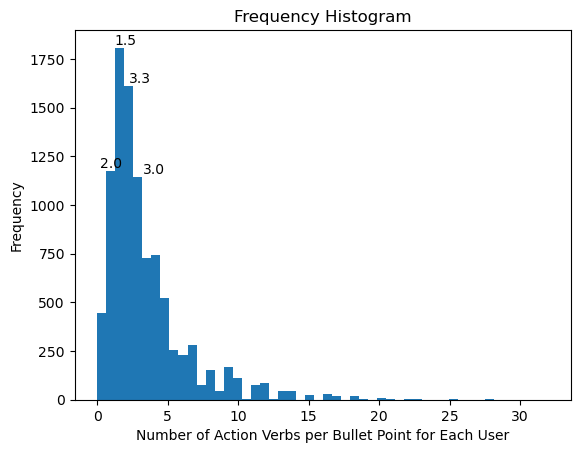

In [120]:
# Calculate the average number of action verbs in each bullet point for each resume
rd4['total_action_verb'] = verb_count
rd4['avg_action_verb'] = rd4['total_action_verb']/rd4['bullet_point_count']
print(rd4['total_action_verb'],rd4['avg_action_verb'])

# Plot a frequency historgram
import matplotlib.pyplot as plt

# Filter out infinite values
filtered_data = [x for x in rd4['avg_action_verb'] if np.isfinite(x)]

plt.hist(filtered_data, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency', xlabel='Number of Action Verbs per Bullet Point for Each User')

bar_positions = [1,2,3,4]  # Indices of the bars to label

for position in bar_positions:
    x_value = filtered_data[position]
    count = plt.gca().patches[position].get_height()
    label = round(x_value, 1)
    plt.text(position, count, str(label), ha='center', va='bottom')

plt.show()

## 3-5 No use of pronouns

In [98]:
# Define a list of 34 pronouns
pronouns = ''' I we you he she it they me us you her him it them mine ours yours hers his theirs my our your her his their myself yourself 
herself himself itself ourselves yourselves themselves'''
pronoun_list = pronouns.split()

# Convert each element to string
pronoun_list = list(map(str, pronoun_list))  

print(pronoun_list)
print(len(pronoun_list))

['I', 'we', 'you', 'he', 'she', 'it', 'they', 'me', 'us', 'you', 'her', 'him', 'it', 'them', 'mine', 'ours', 'yours', 'hers', 'his', 'theirs', 'my', 'our', 'your', 'her', 'his', 'their', 'myself', 'yourself', 'herself', 'himself', 'itself', 'ourselves', 'yourselves', 'themselves']
34


In [99]:
# Count the occurrences of pronouns in each row
pronoun_count = rd4.apply(lambda row: sum(1 for pronoun in pronoun_list if any(re.findall(r'\b{}\b'.format(pronoun), str(row[column]), re.IGNORECASE) for column in rd4.columns)), axis=1)

# Print the result
print("Number of pronouns in each row:")
print(pronoun_count)

Number of pronouns in each row:
0         3
1         1
2         0
3         2
4         1
         ..
11971     0
11972    11
11973     0
11974     8
11975    12
Length: 11976, dtype: int64


In [118]:
# Basic statistical characteristics of the verb_count variable
import numpy as np

min = np.amin(pronoun_count)
max = np.amax(pronoun_count)
mean = round(np.mean(pronoun_count),1)
median = round(np.median(pronoun_count),1)
variance = round(np.var(pronoun_count),1)
sd = round(np.std(pronoun_count),1)

print(min,max,mean,median,variance,sd)

0 14 2.0 1.0 4.8 2.2


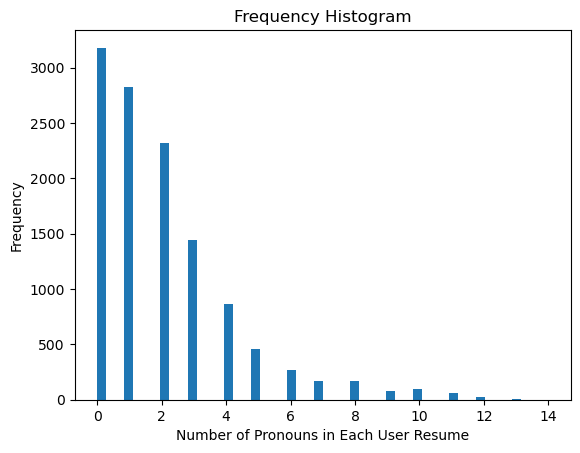

In [117]:
# Add the variable to the data frame
rd4['pronoun_count'] = pronoun_count

# Plot a frequency historgram
import matplotlib.pyplot as plt

# Filter out infinite values
filtered_data = [x for x in rd4['pronoun_count'] if np.isfinite(x)]

plt.hist(filtered_data, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency', xlabel='Number of Pronouns in Each User Resume')

plt.show()